In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import optuna
import torch
from torch import nn
import torch.nn.functional as F
from torch import tensor
import torch.utils.data as Data
import math
from matplotlib import pyplot
from datetime import datetime, timedelta
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import math
import warnings
warnings.filterwarnings("ignore")
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置随机参数：保证实验结果可以重复
SEED=1234
import random
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED) # 适用于显卡训练
torch.cuda.manual_seed_all(SEED) # 适用于多显卡训练
from torch.backends import cudnn
cudnn.benchmark = False
cudnn.deterministic = True

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) #???  为什么这么做
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        # pe.requires_grad = False
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor):
        chunk = x.chunk(x.size(-1), dim=2)
        out = torch.Tensor([]).to(x.device)
        for i in range(len(chunk)):
            out = torch.cat((out, chunk[i] + self.pe[:chunk[i].size(0), ...]), dim=2)
        return out


def transformer_generate_tgt_mask(length, device):
    mask = torch.tril(torch.ones(length, length, device=device)) == 1
    mask = (
        mask.float()
        .masked_fill(mask == 0, float("-inf"))
        .masked_fill(mask == 1, float(0.0))
    )
    return mask


class Transformer(nn.Module):
    """标准的Transformer编码器-解码器结构"""

    def __init__(self, n_encoder_inputs, n_decoder_inputs, Sequence_length, d_model=512, dropout=0.1, num_layer=8):
        """
        初始化
        :param n_encoder_inputs:    输入数据的特征维度
        :param n_decoder_inputs:    编码器输入的特征维度，其实等于编码器输出的特征维度
        :param d_model:             词嵌入特征维度
        :param dropout:             dropout
        :param num_layer:           Transformer块的个数
         Sequence_length:           transformer 输入数据 序列的长度
        """
        super(Transformer, self).__init__()

        self.input_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)
        self.target_pos_embedding = torch.nn.Embedding(500, embedding_dim=d_model)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model, nhead=num_layer, dropout=dropout,dim_feedforward=4 * d_model)
        decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model, nhead=num_layer, dropout=dropout,dim_feedforward=4 * d_model)

        self.encoder = torch.nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.decoder = torch.nn.TransformerDecoder(decoder_layer, num_layers=4)

        self.input_projection = torch.nn.Linear(n_encoder_inputs, d_model)
        self.output_projection = torch.nn.Linear(n_decoder_inputs, d_model)

        self.linear = torch.nn.Linear(d_model, 1)
        self.ziji_add_linear = torch.nn.Linear(Sequence_length,1)

    def encode_in(self, src):
        src_start = self.input_projection(src).permute(1, 0, 2)
        in_sequence_len, batch_size = src_start.size(0), src_start.size(1)
        pos_encoder = (torch.arange(0, in_sequence_len, device=src.device).unsqueeze(0).repeat(batch_size, 1))
        pos_encoder = self.input_pos_embedding(pos_encoder).permute(1, 0, 2)
        src = src_start + pos_encoder
        src = self.encoder(src) + src_start
        return src

    def decode_out(self, tgt, memory):
        tgt_start = self.output_projection(tgt).permute(1, 0, 2)
        out_sequence_len, batch_size = tgt_start.size(0), tgt_start.size(1)
        pos_decoder = (torch.arange(0, out_sequence_len, device=tgt.device).unsqueeze(0).repeat(batch_size, 1))
        pos_decoder = self.target_pos_embedding(pos_decoder).permute(1, 0, 2)
        tgt = tgt_start + pos_decoder
        tgt_mask = transformer_generate_tgt_mask(out_sequence_len, tgt.device)
        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask) + tgt_start
        out = out.permute(1, 0, 2)  # [batch_size, seq_len, d_model]
        out = self.linear(out)
        return out

    def forward(self, src, target_in):
        # print("src.shape", src.shape)
        src = self.encode_in(src)
        # print("src.shape",src.shape)#src.shape torch.Size([9, 8, 512])
        out = self.decode_out(tgt=target_in, memory=src)
        # print("out.shape",out.shape)
        # print("out.shape:",out.shape)# torch.Size([batch, 3, 1]) # 原本代码中的输出
        # 上边的这个输入可以用于很多任务的输出 可以根据任务进行自由的变换
        # 下面是自己修改的
        # 使用全连接变成 [batch,1] 构成了基于transformer的回归单值预测
        out = out.squeeze(2)
        out = self.ziji_add_linear(out)
        return out

In [ ]:
# 用30天的数据(包括这30天所有的因子和log_ret)预测下一天的log_ret
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data = pd.read_csv("factors_data.csv")  # 1 3 7 是 预测列
print(data.columns)
['Date', 'Close-H', 'Close-L', 'W&R', 'DMI', 'CCI', 'ROC', 'ATR', 'ADX','HT_DCPERIOD', 'ma_5', 'ma_30', 'ma_120', 'RSI', 'MACD', 'MACDsignal','OBV', 'AD', 'K', 'D', 'log_ret']
data.dropna(axis=0, how='any')
data_x = data[
    ['Close-H', 'Close-L', 'W&R', 'DMI', 'CCI', 'ROC', 'ATR', 'ADX','HT_DCPERIOD', 'ma_5', 'ma_30', 'ma_120', 'RSI', 'MACD', 'MACDsignal','OBV', 'AD', 'K', 'D', 'log_ret']].values
# ax=plt.subplots(figsize=(50,50))
# ax=sns.heatmap(data.corr(),vmax=.1,square=True,annot=True,annot_kws={"fontsize":8})
# plt.show()
# print(len(data_y))
# 31个数据划分为一组 用前30个预测后一个
data_31_x = []
data_31_y = []
for i in range(0, len(data_x) - 30,31):
    data_31_x.append(data_x[i:i +30])
    data_31_y.append(data_x[i+30][-1])
print(len(data_31_x), len(data_31_y))
x_train, x_test, y_train, y_test = train_test_split(np.array(data_31_x), np.array(data_31_y), test_size=0.2,random_state=1,shuffle=True,)
class DataSet(Data.Dataset):
    def __init__(self, data_inputs, data_targets):
        self.inputs = torch.FloatTensor(data_inputs)
        self.label = torch.FloatTensor(data_targets)

    def __getitem__(self, index):
        return self.inputs[index], self.label[index]

    def __len__(self):
        return len(self.inputs)
Batch_Size = 8  #
DataSet = DataSet(np.array(x_train), list(y_train))
train_size = int(len(x_train) * 0.7)
test_size = len(y_train) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(DataSet, [train_size, test_size])
TrainDataLoader = Data.DataLoader(train_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)
TestDataLoader = Data.DataLoader(test_dataset, batch_size=Batch_Size, shuffle=True, drop_last=True)

model = Transformer(n_encoder_inputs=20, n_decoder_inputs=20, Sequence_length=30).to(device)  # 3 表示Sequence_length  transformer 输入数据 序列的长度
def test_main(model):
    val_epoch_loss = []
    with torch.no_grad():
        for index, (inputs, targets) in enumerate(TestDataLoader):
            inputs = torch.tensor(inputs).to(device)
            targets = torch.tensor(targets).to(device)
            inputs = inputs.float()
            targets = targets.float()
            tgt_in = torch.rand((Batch_Size,30,20))
            tgt_in = tgt_in.to(device)
            outputs = model(inputs, tgt_in)
            # print(outputs.float(), targets.float())
            loss = criterion(outputs.float(), targets.float())
            val_epoch_loss.append(loss.item())
    return np.mean(val_epoch_loss)


epochs = 50 # 100 200
optimizer = torch.optim.Adagrad(model.parameters(), lr=0.0001)
criterion = torch.nn.MSELoss().to(device)

val_loss = []
train_loss = []
best_test_loss = 10000000
for epoch in tqdm(range(epochs)):
    train_epoch_loss = []
    for index, (inputs, targets) in enumerate(TrainDataLoader):
        inputs = torch.tensor(inputs).to(device)
        targets = torch.tensor(targets).to(device)
        inputs = inputs.float()
        targets = targets.float()
        # print("inputs",inputs.shape) # [batch,3，16]
        # print("targets",targets.shape) # targets torch.Size([batch])
        tgt_in = torch.rand((Batch_Size,30,20))  # 输入数据的维度是[batch,序列长度，每个单元的维度]
        tgt_in=tgt_in.to(device)
        outputs = model(inputs, tgt_in)
        # print("outputs.shape:",outputs.shape) # outputs.shape [batch, 3, 1]
        loss = criterion(outputs.float(), targets.float())
        print("loss:", loss)
        loss.backward()
        optimizer.step()
        train_epoch_loss.append(loss.item())
    train_loss.append(np.mean(train_epoch_loss))
    val_epoch_loss = test_main(model)
    val_loss.append(val_epoch_loss)
    print("epoch:", epoch, "train_epoch_loss:", np.mean(train_epoch_loss), "val_epoch_loss:", val_epoch_loss)
    # 保存下来最好的模型：
    if val_epoch_loss < best_test_loss:
        best_test_loss = val_epoch_loss
        best_model = model
        print("best_test_loss -------------------------------------------------", best_test_loss)
        torch.save(best_model.state_dict(), 'mbest.pth')

# 画一下loss图
fig = plt.figure(facecolor='white', figsize=(10, 7))
plt.xlabel('X')
plt.ylabel('Y')
plt.xlim(xmax=len(val_loss), xmin=0)
plt.ylim(ymax=max(max(train_loss), max(val_loss)), ymin=0)
# 画两条（0-9）的坐标轴并设置轴标签x，y
x1 = [i for i in range(0, len(train_loss), 1)]  # 随机产生300个平均值为2，方差为1.2的浮点数，即第一簇点的x轴坐标
y1 = val_loss  # 随机产生300个平均值为2，方差为1.2的浮点数，即第一簇点的y轴坐标
x2 = [i for i in range(0, len(train_loss), 1)]
y2 = train_loss
colors1 = '#00CED4'  # 点的颜色
colors2 = '#DC143C'
area = np.pi * 4 ** 1  # 点面积
# 画散点图
plt.scatter(x1, y1, s=area, c=colors1, alpha=0.4, label='val_loss')
plt.scatter(x2, y2, s=area, c=colors2, alpha=0.4, label='train_loss')
plt.legend()
plt.show()



In [8]:
# 加载模型预测------
model = Transformer(n_encoder_inputs=20, n_decoder_inputs=20, Sequence_length=30).to(device)
model.load_state_dict(torch.load('best_Transformer_trainModel.pth'))
model.to(device)
model.eval()
# 在对模型进行评估时，应该配合使用with torch.no_grad() 与 model.eval()：
y_pred = []
y_true = []
with torch.no_grad():
    with torch.no_grad():
        val_epoch_loss = []
        for index, (inputs, targets) in enumerate(TestDataLoader):
            inputs = torch.tensor(inputs).to(device)
            targets = torch.tensor(targets).to(device)
            inputs = inputs.float()
            targets = targets.float()
            tgt_in = torch.rand((Batch_Size,30,20))
            tgt_in = tgt_in.to(device)
            outputs = model(inputs, tgt_in)
            outputs = list(outputs.cpu().numpy().reshape([1, -1])[0])  # 转化为1行列数不指定
            targets = list(targets.cpu().numpy().reshape([1, -1])[0])
            y_pred.extend(outputs)
            y_true.extend(targets)


y_true = np.array(y_true)
y_pred = np.array(y_pred)
print(y_true.shape)
print(y_pred.shape)
# 画折线图显示----
dataframe = pd.DataFrame({'pred': y_pred,'true': y_true})
dataframe.to_csv("bijiao2.csv", index=False, sep=',')

print("y_pred", y_pred)
print("y_true", y_true)

(32,)
(32,)
y_pred [-0.00541032  0.00315998  0.00587908 -0.00619223 -0.00910532 -0.02101216
  0.01894031  0.008292    0.01179767 -0.0139722  -0.00078418 -0.0049605
  0.02485902 -0.01393912 -0.00774696  0.0012353   0.00441534  0.0165189
 -0.01857743 -0.00059653 -0.00654181  0.00305381  0.0005701   0.00065845
  0.02355566 -0.00121153  0.026892   -0.01812699  0.00024562  0.01369867
 -0.00970253 -0.00997368]
y_true [ 0.01704719  0.00818376 -0.01235504  0.00519171 -0.01564871  0.00387194
 -0.01954371 -0.01813259  0.01139802  0.01710685 -0.0078609   0.00417447
 -0.00934526 -0.0034552  -0.02316582  0.00935623  0.02367766 -0.02643184
 -0.01301028 -0.00390345 -0.00545225 -0.01088467  0.01954159  0.00066121
  0.0011592  -0.02025381 -0.01592441  0.0087192   0.00867093  0.00058593
  0.00542988 -0.02052212]


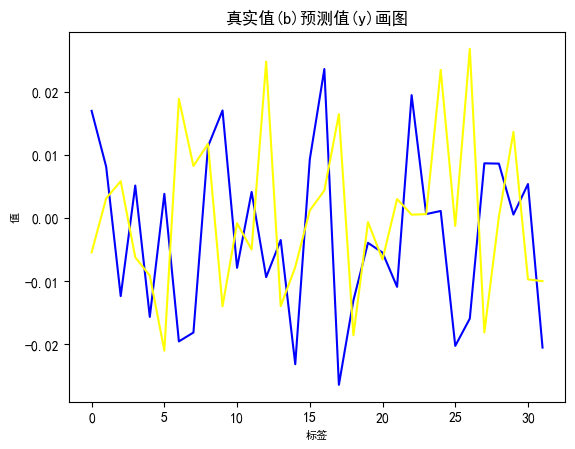

In [9]:
len_ = [i for i in range(len(y_pred[0:1000]))]
plt.xlabel('标签', fontsize=8)
plt.ylabel('值', fontsize=8)
plt.plot(len_, y_true[0:1000], color="blue" ,label='y_true')
plt.plot(len_, y_pred[0:1000], color="yellow", label='y_pred')
plt.title("真实值(b)预测值(y)画图")
plt.show()

In [36]:
import matplotlib as mpl
print(mpl.get_cachedir())

/home/zxy/.cache/matplotlib


In [7]:
# 加载模型------
model = Transformer(n_encoder_inputs=20, n_decoder_inputs=20, Sequence_length=30)
model.load_state_dict(torch.load('best_Transformer_trainModel.pth'))

<All keys matched successfully>

In [31]:
sum_name=0
sum_para=0
for name,para in model.named_parameters():
    print(f'{name:50} {para.numel():10}')
    sum_name+=1
    sum_para+=para.numel()
    # if name=='ziji_add_linear.weight':
    #     print(para)
    #     print(len(para))
    #     print(para.numel())
print(sum_name)
print(sum_para)

input_pos_embedding.weight                             256000
target_pos_embedding.weight                            256000
encoder.layers.0.self_attn.in_proj_weight              786432
encoder.layers.0.self_attn.in_proj_bias                  1536
encoder.layers.0.self_attn.out_proj.weight             262144
encoder.layers.0.self_attn.out_proj.bias                  512
encoder.layers.0.linear1.weight                       1048576
encoder.layers.0.linear1.bias                            2048
encoder.layers.0.linear2.weight                       1048576
encoder.layers.0.linear2.bias                             512
encoder.layers.0.norm1.weight                             512
encoder.layers.0.norm1.bias                               512
encoder.layers.0.norm2.weight                             512
encoder.layers.0.norm2.bias                               512
encoder.layers.1.self_attn.in_proj_weight              786432
encoder.layers.1.self_attn.in_proj_bias                  1536
encoder.